# Mecklenburg County Sheriff's Office

Date: April 18, 2022

In [116]:
import logging


def configure_root_logger():
    console_logger = logging.StreamHandler()
    console_logger.setLevel(logging.DEBUG)
    console_logger.setFormatter(
        logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
    )

    logger = logging.getLogger()
    logger.handlers = []  # reset handlers in case this cell is re-run
    logger.setLevel(logging.DEBUG)
    logger.addHandler(console_logger)
    return logger

In [117]:
import os

from sqlalchemy import create_engine

from dash import Dash, html, dcc
import plotly.express as px
import pandas as pd

In [118]:
logger = configure_root_logger()
pg_engine = create_engine(os.getenv("DATABASE_URL"))
pg_conn = pg_engine.connect()

In [180]:
agency_id = pd.read_sql(
    f"""
    SELECT
        id
        , name
    FROM nc_agency
    WHERE name ~ 'Mecklenburg County'
    """,
    pg_conn,
).iloc[0]['id']
agency_id

168

In [120]:
mecklenburg_stops_sql = f"""
SELECT
    id
    , year
    , (CASE WHEN driver_ethnicity = 'H' THEN 'Hispanic'
            WHEN driver_ethnicity = 'N' AND driver_race = 'A' THEN 'Asian'
            WHEN driver_ethnicity = 'N' AND driver_race = 'B' THEN 'Black'
            WHEN driver_ethnicity = 'N' AND driver_race = 'I' THEN 'Native American'
            WHEN driver_ethnicity = 'N' AND driver_race = 'U' THEN 'Other'
            WHEN driver_ethnicity = 'N' AND driver_race = 'W' THEN 'White'
       END) as driver_race
    , (CASE WHEN stop_purpose = 1 THEN 'Speed Limit Violation'
            WHEN stop_purpose = 2 THEN 'Stop Light/Sign Violation'
            WHEN stop_purpose = 3 THEN 'Driving While Impaired'
            WHEN stop_purpose = 4 THEN 'Safe Movement Violation'
            WHEN stop_purpose = 5 THEN 'Vehicle Equipment Violation'
            WHEN stop_purpose = 6 THEN 'Vehicle Regulatory Violation'
            WHEN stop_purpose = 7 THEN 'Seat Belt Violation'
            WHEN stop_purpose = 8 THEN 'Investigation'
            WHEN stop_purpose = 9 THEN 'Other Motor Vehicle Violation'
            WHEN stop_purpose = 10 THEN 'Checkpoint'
       END) as stop_purpose
    , (CASE WHEN search_type = 1 THEN 'Consent'
            WHEN search_type = 2 THEN 'Search Warrant'
            WHEN search_type = 3 THEN 'Probable Cause'
            WHEN search_type = 4 THEN 'Search Incident to Arrest'
            WHEN search_type = 5 THEN 'Protective Frisk'
            ELSE ''
       END) as search_type
    , contraband_found
    , engage_force
    , count
FROM nc_stopsummary
WHERE
    agency_id = {agency_id}
ORDER BY 1, 2, 3
"""

# Traffic Stops

Shows the race/ethnic composition of drivers stopped by this department over time.

https://staging.nccopwatch.org/agencies/168/traffic-stops

In [188]:
df = pd.read_sql(
    f"""
    WITH mecklenburg_yearly_stops AS ({mecklenburg_stops_sql})
    SELECT
        year
        , driver_race
        , SUM(count) AS count
    FROM mecklenburg_yearly_stops
    GROUP BY 1, 2
    ORDER BY 2, 1
    """,
    pg_conn,
)
df['%'] = df['count'] / df.groupby('year')['count'].transform('sum') * 100
df.pivot(index='year', columns='driver_race', values=['count', '%'])

count                                                         %  \
driver_race  Asian   Black Hispanic Native American  Other   White     Asian   
year                                                                           
2002          10.0   344.0    137.0             2.0   19.0   392.0  1.106195   
2003           5.0   254.0     81.0             1.0    8.0   242.0  0.846024   
2004           5.0   123.0     24.0             1.0    3.0    89.0  2.040816   
2005           2.0    59.0      6.0             NaN    3.0    42.0  1.785714   
2006           1.0    61.0     19.0             NaN    2.0    56.0  0.719424   
2007           3.0   112.0     34.0             1.0    5.0   110.0  1.132075   
2008           4.0    76.0     27.0             2.0    NaN    89.0  2.020202   
2009           2.0    65.0     22.0             1.0    3.0    65.0  1.265823   
2010           4.0    50.0     22.0             8.0    2.0    55.0  2.836879   
2011           4.0    46.0     21.0             1.0    2.0    27.0  3.960396   
2012           1.0    34.0     10.0             4.0    1.0    30.0  1.250000   
2013           5.0   117.0     24.0             3.0    2.0    96.0  2.024291   
2014          70.0  1345.0    272.0            17.0   76.0  1113.0  2.419634   
2015         152.0  3104.0    612.0            50.0  163.0  2565.0  2.287090   
2016          54.0  1124.0    249.0            24.0   57.0   854.0  2.286198   
2017          39.0   950.0    233.0            20.0   51.0   664.0  1.992846   
2018          89.0  2113.0    500.0            25.0  140.0  1394.0  2.088712   
2019          86.0  1655.0    413.0            17.0  128.0  1240.0  2.430065   
2020         105.0  3021.0    752.0            42.0  155.0  2165.0  1.682692   
2021         150.0  3978.0   1247.0            37.0  264.0  2605.0  1.811375   
2022          25.0   472.0    138.0             1.0   30.0   271.0  2.668090   

                                                                        
driver_race      Black   Hispanic Native American     Other      White  
year                                                                    
2002         38.053097  15.154867        0.221239  2.101770  43.362832  
2003         42.978003  13.705584        0.169205  1.353638  40.947547  
2004         50.204082   9.795918        0.408163  1.224490  36.326531  
2005         52.678571   5.357143             NaN  2.678571  37.500000  
2006         43.884892  13.669065             NaN  1.438849  40.287770  
2007         42.264151  12.830189        0.377358  1.886792  41.509434  
2008         38.383838  13.636364        1.010101       NaN  44.949495  
2009         41.139241  13.924051        0.632911  1.898734  41.139241  
2010         35.460993  15.602837        5.673759  1.418440  39.007092  
2011         45.544554  20.792079        0.990099  1.980198  26.732673  
2012         42.500000  12.500000        5.000000  1.250000  37.500000  
2013         47.368421   9.716599        1.214575  0.809717  38.866397  
2014         46.491531   9.402005        0.587625  2.627031  38.472174  
2015         46.704785   9.208546        0.752332  2.452603  38.594643  
2016         47.586791  10.541914        1.016088  2.413209  36.155800  
2017         48.543689  11.905979        1.021972  2.606030  33.929484  
2018         49.589298  11.734335        0.586717  3.285614  32.715325  
2019         46.764623  11.669963        0.480362  3.616841  35.038146  
2020         48.413462  12.051282        0.673077  2.483974  34.695513  
2021         48.037677  15.058568        0.446806  3.188021  31.457553  
2022         50.373533  14.727855        0.106724  3.201708  28.922092

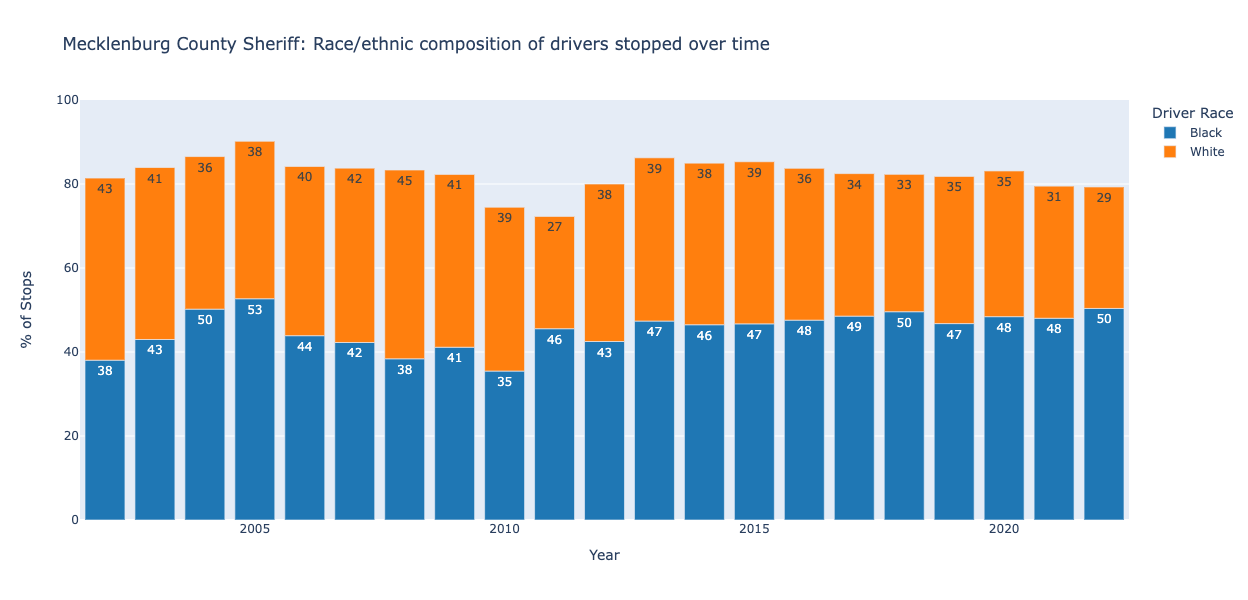

In [187]:
df = df[df['driver_race'].isin(['Black', 'White'])]
px.bar(
    df,
    x="year",
    y='%',
    color="driver_race",
    text_auto='.2s',
    title="Mecklenburg County Sheriff: Race/ethnic composition of drivers stopped over time",
    labels={'year':'Year', '%':'% of Stops', "driver_race": "Driver Race"},
    color_discrete_sequence=px.colors.qualitative.D3,
    height=600,
    range_y=[0, 100],
)

# Searches

https://staging.nccopwatch.org/agencies/168/searches

In [230]:
df = pd.read_sql(
    f"""
    WITH mecklenburg_yearly_stops AS ({mecklenburg_stops_sql})
    SELECT
        year
        , driver_race
        , SUM(count) FILTER (WHERE search_type = '') AS stops
        , SUM(count) FILTER (WHERE search_type <> '') AS stops_and_searches
        , SUM(count) AS total
    FROM mecklenburg_yearly_stops
    GROUP BY 1, 2
    ORDER BY 2, 1
    """,
    pg_conn,
)
df['stops_and_searches'] = df['stops_and_searches'].fillna(0)
df['% of Stops'] = df['stops_and_searches'] / df['total'] * 100
df = df[df['driver_race'].isin(['Black', 'White'])]
df.pivot(index='year', columns='driver_race', values=['stops', 'stops_and_searches', 'total', '% of Stops'])

stops         stops_and_searches         total          \
driver_race   Black   White              Black White   Black   White   
year                                                                   
2002          300.0   367.0               44.0  25.0   344.0   392.0   
2003          222.0   226.0               32.0  16.0   254.0   242.0   
2004          112.0    81.0               11.0   8.0   123.0    89.0   
2005           57.0    37.0                2.0   5.0    59.0    42.0   
2006           58.0    54.0                3.0   2.0    61.0    56.0   
2007          105.0   105.0                7.0   5.0   112.0   110.0   
2008           70.0    86.0                6.0   3.0    76.0    89.0   
2009           63.0    64.0                2.0   1.0    65.0    65.0   
2010           50.0    55.0                0.0   0.0    50.0    55.0   
2011           46.0    27.0                0.0   0.0    46.0    27.0   
2012           32.0    30.0                2.0   0.0    34.0    30.0   
2013          110.0    96.0                7.0   0.0   117.0    96.0   
2014         1332.0  1107.0               13.0   6.0  1345.0  1113.0   
2015         3090.0  2559.0               14.0   6.0  3104.0  2565.0   
2016         1119.0   852.0                5.0   2.0  1124.0   854.0   
2017          940.0   659.0               10.0   5.0   950.0   664.0   
2018         2104.0  1393.0                9.0   1.0  2113.0  1394.0   
2019         1653.0  1238.0                2.0   2.0  1655.0  1240.0   
2020         3015.0  2162.0                6.0   3.0  3021.0  2165.0   
2021         3967.0  2602.0               11.0   3.0  3978.0  2605.0   
2022          470.0   271.0                2.0   0.0   472.0   271.0   

            % of Stops             
driver_race      Black      White  
year                               
2002         12.790698   6.377551  
2003         12.598425   6.611570  
2004          8.943089   8.988764  
2005          3.389831  11.904762  
2006          4.918033   3.571429  
2007          6.250000   4.545455  
2008          7.894737   3.370787  
2009          3.076923   1.538462  
2010          0.000000   0.000000  
2011          0.000000   0.000000  
2012          5.882353   0.000000  
2013          5.982906   0.000000  
2014          0.966543   0.539084  
2015          0.451031   0.233918  
2016          0.444840   0.234192  
2017          1.052632   0.753012  
2018          0.425935   0.071736  
2019          0.120846   0.161290  
2020          0.198610   0.138568  
2021          0.276521   0.115163  
2022          0.423729   0.000000

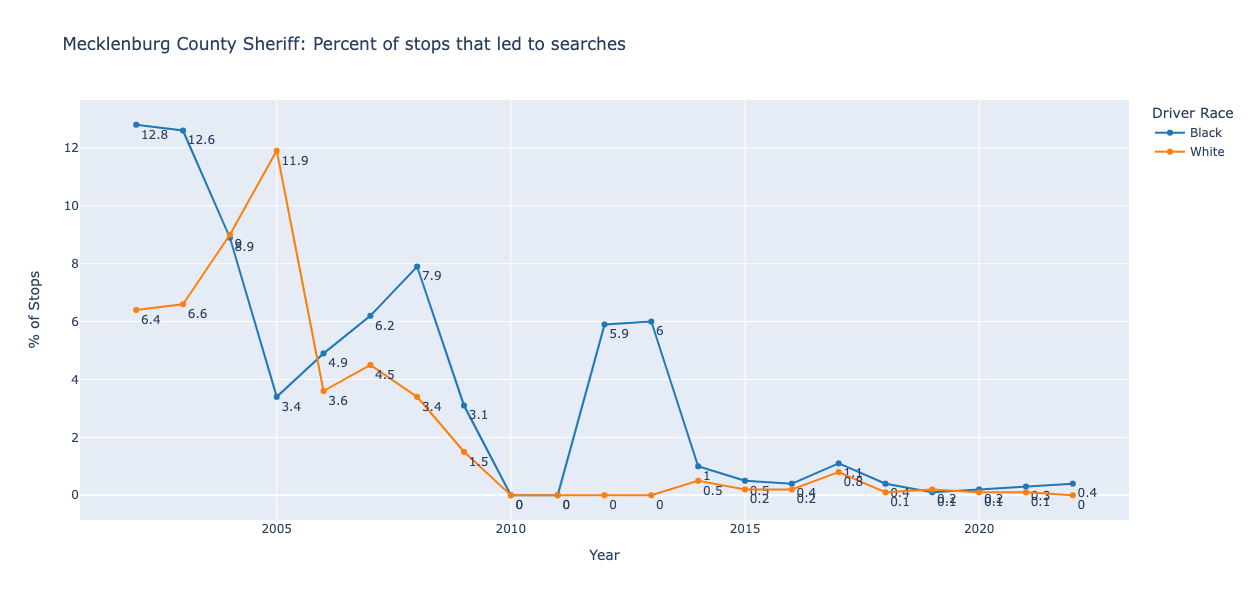

In [231]:
df['% of Stops'] = df['% of Stops'].round(1)
fig = px.line(
    df,
    x="year",
    y='% of Stops',
    color="driver_race",
    title="Mecklenburg County Sheriff: Percent of stops that led to searches",
    text='% of Stops',
    labels={'year':'Year', '% of Stops': '% of Stops', "driver_race": "Driver Race"},
    color_discrete_sequence=px.colors.qualitative.D3,
    height=600,
    markers=True,
)
fig.update_traces(textposition="bottom right")

## Stops by Purpose

From Whitley (4/13):

> Get data on regulatory + equipment stops vs. moving violations for Mecklenburg County Sheriff Dept.

https://staging.nccopwatch.org/agencies/168/traffic-stops

#### Traffic Stops by Count

https://staging.nccopwatch.org/agencies/168/traffic-stops

In [265]:
df = pd.read_sql(
    f"""
    WITH mecklenburg_yearly_stops AS ({mecklenburg_stops_sql})
    SELECT
        year
        , driver_race
        , stop_purpose
        , SUM(count) AS count
    FROM mecklenburg_yearly_stops
    GROUP BY 1, 2, 3
    ORDER BY 2, 1, 3
    """,
    pg_conn,
)
pivot = df.pivot(index=['year', 'stop_purpose'], columns='driver_race', values='count').fillna(0)
pivot.to_csv("mecklenburg-sheriff-2022-04-stop-purpose-counts.csv")
df[df.year > 2018].pivot(index=['year', 'stop_purpose'], columns='driver_race', values='count').fillna(0)

driver_race                         Asian   Black  Hispanic  Native American  \
year stop_purpose                                                              
2019 Driving While Impaired           0.0     1.0       0.0              0.0   
     Investigation                    0.0     9.0       5.0              0.0   
     Other Motor Vehicle Violation    7.0   115.0      40.0              3.0   
     Safe Movement Violation          4.0   117.0      48.0              0.0   
     Seat Belt Violation              1.0    14.0       9.0              0.0   
     Speed Limit Violation           45.0   798.0     195.0              7.0   
     Stop Light/Sign Violation       20.0   311.0      79.0              5.0   
     Vehicle Equipment Violation      3.0    55.0      10.0              1.0   
     Vehicle Regulatory Violation     6.0   235.0      27.0              1.0   
2020 Driving While Impaired           0.0     1.0       2.0              0.0   
     Investigation                    0.0     6.0       2.0              0.0   
     Other Motor Vehicle Violation    1.0   148.0      22.0              1.0   
     Safe Movement Violation          7.0   161.0      56.0              5.0   
     Seat Belt Violation              0.0    42.0       8.0              1.0   
     Speed Limit Violation           78.0  2145.0     535.0             20.0   
     Stop Light/Sign Violation       17.0   326.0      99.0             12.0   
     Vehicle Equipment Violation      1.0    70.0      13.0              1.0   
     Vehicle Regulatory Violation     1.0   122.0      15.0              2.0   
2021 Checkpoint                       0.0    30.0      25.0              0.0   
     Investigation                    0.0     3.0       1.0              0.0   
     Other Motor Vehicle Violation    2.0   141.0      52.0              3.0   
     Safe Movement Violation          6.0   152.0      43.0              1.0   
     Seat Belt Violation              0.0    49.0      12.0              0.0   
     Speed Limit Violation          121.0  2842.0     915.0             28.0   
     Stop Light/Sign Violation       17.0   463.0     131.0              4.0   
     Vehicle Equipment Violation      3.0    77.0      24.0              0.0   
     Vehicle Regulatory Violation     1.0   221.0      44.0              1.0   
2022 Checkpoint                       0.0     8.0       2.0              0.0   
     Investigation                    0.0     0.0       1.0              0.0   
     Other Motor Vehicle Violation    1.0    15.0       3.0              0.0   
     Safe Movement Violation          1.0    13.0       3.0              0.0   
     Seat Belt Violation              0.0     3.0       0.0              0.0   
     Speed Limit Violation           17.0   346.0     108.0              0.0   
     Stop Light/Sign Violation        4.0    32.0      13.0              1.0   
     Vehicle Equipment Violation      1.0    18.0       4.0              0.0   
     Vehicle Regulatory Violation     1.0    37.0       4.0              0.0   

driver_race                         Other   White  
year stop_purpose                                  
2019 Driving While Impaired           0.0     1.0  
     Investigation                    0.0     9.0  
     Other Motor Vehicle Violation    2.0    51.0  
     Safe Movement Violation          8.0    69.0  
     Seat Belt Violation              1.0     7.0  
     Speed Limit Violation           78.0   730.0  
     Stop Light/Sign Violation       28.0   200.0  
     Vehicle Equipment Violation      2.0    28.0  
     Vehicle Regulatory Violation     9.0   145.0  
2020 Driving While Impaired           0.0     0.0  
     Investigation                    0.0     3.0  
     Other Motor Vehicle Violation    3.0    54.0  
     Safe Movement Violation          6.0   136.0  
     Seat Belt Violation              2.0    21.0  
     Speed Limit Violation          126.0  1675.0  
     Stop Light/Sign Violation       15.0   184.0  
     Vehicle Equipment 

## Traffic Stops by Stop Purpose Group

From Frank and Mike's research, [Re-prioritizing traffic stops to reduce motor vehicle crash outcomes and racial disparities](https://injepijournal.biomedcentral.com/articles/10.1186/s40621-019-0227-6):

> Law enforcement agencies have wide latitude in enforcement, including prioritization of stop types:
> 1. Safety (e.g. moving violation) stops
> 2. Investigatory stops
> 3. Economic (regulatory and equipment) stops

In [250]:
df = pd.read_sql(
    f"""
    WITH mecklenburg_yearly_stops AS ({mecklenburg_stops_sql})
    SELECT
        driver_race
        , (CASE WHEN stop_purpose IN ('Speed Limit Violation', 'Stop Light/Sign Violation', 'Safe Movement Violation') THEN 'Moving Violation'
                WHEN stop_purpose IN ('Investigation', 'Checkpoint') THEN 'Investigatory'
                WHEN stop_purpose IN ('Vehicle Equipment Violation', 'Vehicle Regulatory Violation', 'Seat Belt Violation') THEN 'Regulatory and Equipment'
                ELSE 'Other'
           END) as stop_purpose_group
        , SUM(count) AS count
    FROM mecklenburg_yearly_stops
    GROUP BY 1, 2
    ORDER BY 1, 3 DESC
    """,
    pg_conn,
)
df['% of Stops'] = df['count'] / df.groupby('driver_race')['count'].transform('sum') * 100
df

,driver_race,stop_purpose_group,count,% of Stops
0,Asian,Moving Violation,713,87.377451
1,Asian,Regulatory and Equipment,56,6.862745
2,Asian,Other,45,5.514706
3,Asian,Investigatory,2,0.245098
4,Black,Moving Violation,14837,77.668429
5,Black,Regulatory and Equipment,2733,14.306653
6,Black,Other,1327,6.946553
7,Black,Investigatory,206,1.078365
8,Hispanic,Moving Violation,3974,82.056577
9,Hispanic,Regulatory and Equipment,435,8.982036


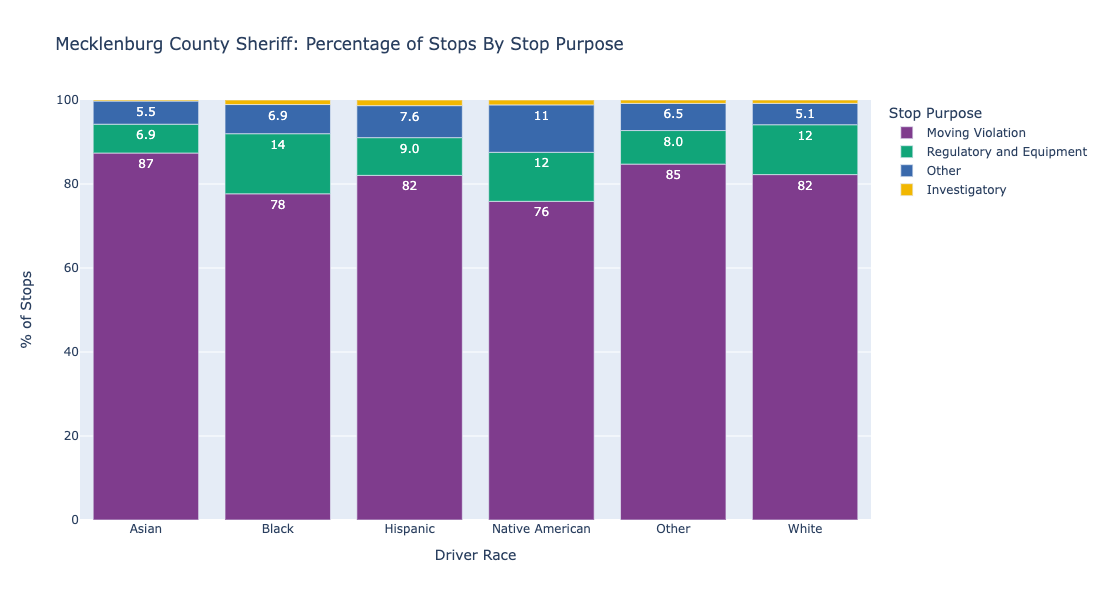

In [251]:
px.bar(
    df,
    x="driver_race",
    y='% of Stops',
    color="stop_purpose_group",
    text_auto='.2s',
    title="Mecklenburg County Sheriff: Percentage of Stops By Stop Purpose",
    labels={'year':'Year', '% of Stops':'% of Stops', "driver_race": "Driver Race", "stop_purpose_group": "Stop Purpose"},
    color_discrete_sequence=px.colors.qualitative.Bold,
    height=600,
    range_y=[0, 100],
)

## Save Mecklenburg County Sheriff's Office Data to CSV

In [236]:
df = pd.read_sql(
    f"""
    WITH mecklenburg_yearly_stops AS ({mecklenburg_stops_sql})
    SELECT
        year
        , driver_race
        , stop_purpose
        , search_type
        , contraband_found
        , engage_force
        , count
    FROM mecklenburg_yearly_stops
    ORDER BY 1, 2, 3, 4, 5, 6
    """,
    pg_conn,
)
df.to_csv("mecklenburg-sheriff-2022-04.csv", index=False)

### Export?

<div class="alert-info">
<strong>Question: Perhaps this entire view should be exportable by department?</strong>
</div>

In [246]:
df = pd.read_sql(
    f"""
    WITH mecklenburg_yearly_stops AS ({mecklenburg_stops_sql})
    SELECT
        a.name
        , sum(count) AS total_stops
        , count(*) AS csv_row_count
    FROM nc_stopsummary s
    JOIN nc_agency a ON (a.id = s.agency_id)
    GROUP BY 1
    ORDER BY csv_row_count DESC
    LIMIT 12
    """,
    pg_conn,
)
df

,name,total_stops,csv_row_count
0,NC State Highway Patrol,12094493,666061
1,Charlotte-Mecklenburg Police Department,2038802,334924
2,Raleigh Police Department,1078079,172735
3,Greensboro Police Department,679653,123962
4,Fayetteville Police Department,725221,95484
5,Winston-Salem Police Department,561945,93142
6,Durham Police Department,351315,77500
7,High Point Police Department,387110,69259
8,Wake County Sheriff's Office,178474,47873
9,Wilmington Police Department,270692,47083
